# 1. dataset 

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time 
import optuna
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import font_manager

# sklearn 관련
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.inspection import permutation_importance
import statsmodels.api as sm 
from time import time

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer


# 전처리 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE

# lightgbm 관련
from lightgbm import LGBMRegressor
from lightgbm import plot_importance

In [3]:
# 한글 폰트 경로 설정
font_path = '/System/Library/Fonts/AppleSDGothicNeo.ttc'
font_name = font_manager.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)

In [5]:
data = pd.read_csv('combined_data.csv', encoding = "cp949")
data.head()
print(data.shape) 

(182625, 22)


/var/folders/43/hgp9_8n93yx4p_9ccg75x9n40000gn/T/ipykernel_4153/2429463808.py:1: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('combined_data.csv', encoding = "cp949")


In [6]:
# Checking for null values
print(data.info())

# Checking for outliers
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182625 entries, 0 to 182624
Data columns (total 22 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   day_of_reg     182625 non-null  object 
 1   pick_rgn2_nm   182625 non-null  object 
 2   rider_cnt      182625 non-null  float64
 3   order_cnt      182625 non-null  int64  
 4   datetime       182625 non-null  object 
 5   hour_reg       182625 non-null  int64  
 6   reg_date       182625 non-null  object 
 7   rain_c         182625 non-null  float64
 8   snow_c         182625 non-null  float64
 9   is_rain        182625 non-null  int64  
 10  is_rain2       182625 non-null  int64  
 11  rain_group     182625 non-null  object 
 12  month          182625 non-null  int64  
 13  is_holiday     182625 non-null  int64  
 14  is_weekend     182625 non-null  int64  
 15  holiday_yn     56250 non-null   object 
 16  rider_cnt_w_1  182625 non-null  float64
 17  rider_cnt_w_2  182625 non-nul

In [7]:
data["datetime"] = pd.to_datetime(data["datetime"])
data["reg_date"] = pd.to_datetime(data["reg_date"])

data = data.sort_values(by="datetime")

In [8]:
data = data.drop(columns = ['holiday_yn'])
print(data.head())

   day_of_reg pick_rgn2_nm  rider_cnt  order_cnt            datetime   
0         토요일          강남구      189.0        329 2022-01-29 09:00:00  \
24        토요일          중랑구       33.0         44 2022-01-29 09:00:00   
23        토요일           중구       27.0         35 2022-01-29 09:00:00   
22        토요일          종로구       17.0         18 2022-01-29 09:00:00   
21        토요일          은평구       54.0         98 2022-01-29 09:00:00   

    hour_reg   reg_date  rain_c  snow_c  is_rain  ...  rain_group month   
0          9 2022-01-29     0.0     0.0        0  ...          no     1  \
24         9 2022-01-29     0.0     0.0        0  ...          no     1   
23         9 2022-01-29     0.0     0.0        0  ...          no     1   
22         9 2022-01-29     0.0     0.0        0  ...          no     1   
21         9 2022-01-29     0.0     0.0        0  ...          no     1   

    is_holiday  is_weekend  rider_cnt_w_1  rider_cnt_w_2  rider_cnt_w_3   
0            0           1          211.0

In [9]:
# data = data.dropna(subset=['rider_cnt_w_4'])
data.isna().sum()
#print(data.shape) 

day_of_reg       0
pick_rgn2_nm     0
rider_cnt        0
order_cnt        0
datetime         0
hour_reg         0
reg_date         0
rain_c           0
snow_c           0
is_rain          0
is_rain2         0
rain_group       0
month            0
is_holiday       0
is_weekend       0
rider_cnt_w_1    0
rider_cnt_w_2    0
rider_cnt_w_3    0
rider_cnt_w_4    0
order_cnt_w_1    0
group_s          0
dtype: int64

In [11]:
# category  - pick_rgn2_nm, hour_reg, day_of_reg, is_rain, month, week, is_holiday
for col in ['day_of_reg','pick_rgn2_nm', 'hour_reg', 'day_of_reg','rain_group', 'is_holiday','is_weekend', 'group_s'] : 
    data[col] = data[col].astype('category')

print(data.dtypes)


day_of_reg             category
pick_rgn2_nm           category
rider_cnt               float64
order_cnt                 int64
datetime         datetime64[ns]
hour_reg               category
reg_date         datetime64[ns]
rain_c                  float64
snow_c                  float64
is_rain                   int64
is_rain2                  int64
rain_group             category
month                     int64
is_holiday             category
is_weekend             category
rider_cnt_w_1           float64
rider_cnt_w_2           float64
rider_cnt_w_3           float64
rider_cnt_w_4           float64
order_cnt_w_1             int64
group_s                category
dtype: object


# 2. 데이터 전처리

In [ ]:
# numeric 변수 scale 
# scaler = StandardScaler()  #평균 0 , 분산 1로 조정
# #scaler = MinMaxScaler()

# num_vars = ['rider_cnt_2', 'rider_cnt_w_1', 'rider_cnt_w_2', 'rider_cnt_w_3',
#             'rider_cnt_w_4', 'order_cnt_w_1', 'order_cnt_w_2', 'order_cnt_w_3',
#             'order_cnt_w_4']
# data[num_vars] = scaler.fit_transform(data[num_vars])

# print(df.head(3))

## 2-1. one-hot-encoding

In [ ]:
# ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [3])], remainder='passthrough')
# X = np.array(ct.fit_transform(X))

In [32]:
#df = data.drop(columns = ['is_rain','is_holiday','day_of_reg'])
df = data
var = ['day_of_reg', 'pick_rgn2_nm','hour_reg','is_rain', 'is_rain2','group_s', 
       'is_holiday','is_weekend' , 'rain_group', 'month']
encoder = OneHotEncoder()
onehot = pd.DataFrame(encoder.fit_transform(data[var]).toarray(), columns=encoder.get_feature_names_out(var), index = data.index)
df = pd.concat([onehot, df.drop(columns=var)], axis=1)
#print(df.head(3))
print(df.columns)

Index(['day_of_reg_금요일', 'day_of_reg_목요일', 'day_of_reg_수요일', 'day_of_reg_월요일',
       'day_of_reg_일요일', 'day_of_reg_토요일', 'day_of_reg_화요일',
       'pick_rgn2_nm_강남구', 'pick_rgn2_nm_강동구', 'pick_rgn2_nm_강북구',
       'pick_rgn2_nm_강서구', 'pick_rgn2_nm_관악구', 'pick_rgn2_nm_광진구',
       'pick_rgn2_nm_구로구', 'pick_rgn2_nm_금천구', 'pick_rgn2_nm_노원구',
       'pick_rgn2_nm_도봉구', 'pick_rgn2_nm_동대문구', 'pick_rgn2_nm_동작구',
       'pick_rgn2_nm_마포구', 'pick_rgn2_nm_서대문구', 'pick_rgn2_nm_서초구',
       'pick_rgn2_nm_성동구', 'pick_rgn2_nm_성북구', 'pick_rgn2_nm_송파구',
       'pick_rgn2_nm_양천구', 'pick_rgn2_nm_영등포구', 'pick_rgn2_nm_용산구',
       'pick_rgn2_nm_은평구', 'pick_rgn2_nm_종로구', 'pick_rgn2_nm_중구',
       'pick_rgn2_nm_중랑구', 'hour_reg_9', 'hour_reg_10', 'hour_reg_11',
       'hour_reg_12', 'hour_reg_13', 'hour_reg_14', 'hour_reg_15',
       'hour_reg_16', 'hour_reg_17', 'hour_reg_18', 'hour_reg_19',
       'hour_reg_20', 'hour_reg_21', 'hour_reg_22', 'hour_reg_23', 'is_rain_0',
       'is_rain_1', 'is_rain2_0', 'is

# 3. train, test set split

In [36]:
# train_ratio = 0.8
# total_samples = df.shape[0]
# train_samples = int(train_ratio * total_samples)
# df_train = df[:train_samples]
# df_test = df[train_samples:]

df_train = df[df["datetime"]<= '2022-12-31']
df_test = df[df["datetime"] >= '2023-01-01']

# print(df_train['reg_date'].min()) #2022-01-29
# print(df_test['reg_date'].min()) #2023-02-15

# print(df_train['reg_date'].max()) #2023-02-15
# print(df_test['reg_date'].max()) #2023-05-21

df_train = df_train.drop(columns = ['datetime', 'reg_date','order_cnt'])
df_test = df_test.drop(columns = ['datetime', 'reg_date', 'order_cnt'])
print(df_train.shape, df_test.shape) # 126,000, 54375 / 33000 11250 

(126000, 88) (56250, 88)


In [37]:
# X_train, y_train 나누기
 
# X_train = train.iloc[:, :-1]
# y_train = df_train.iloc[:, -1]

# X_test = df_test.iloc[:, :-1]
# y_test = df_test.iloc[:, -1]

X_train = df_train.drop(columns=['rider_cnt'])
y_train = df_train['rider_cnt']

X_test = df_test.drop(columns=['rider_cnt'])
y_test = df_test['rider_cnt']

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(126000, 87) (126000,) (56250, 87) (56250,)


In [38]:
print(X_train.columns)

Index(['day_of_reg_금요일', 'day_of_reg_목요일', 'day_of_reg_수요일', 'day_of_reg_월요일',
       'day_of_reg_일요일', 'day_of_reg_토요일', 'day_of_reg_화요일',
       'pick_rgn2_nm_강남구', 'pick_rgn2_nm_강동구', 'pick_rgn2_nm_강북구',
       'pick_rgn2_nm_강서구', 'pick_rgn2_nm_관악구', 'pick_rgn2_nm_광진구',
       'pick_rgn2_nm_구로구', 'pick_rgn2_nm_금천구', 'pick_rgn2_nm_노원구',
       'pick_rgn2_nm_도봉구', 'pick_rgn2_nm_동대문구', 'pick_rgn2_nm_동작구',
       'pick_rgn2_nm_마포구', 'pick_rgn2_nm_서대문구', 'pick_rgn2_nm_서초구',
       'pick_rgn2_nm_성동구', 'pick_rgn2_nm_성북구', 'pick_rgn2_nm_송파구',
       'pick_rgn2_nm_양천구', 'pick_rgn2_nm_영등포구', 'pick_rgn2_nm_용산구',
       'pick_rgn2_nm_은평구', 'pick_rgn2_nm_종로구', 'pick_rgn2_nm_중구',
       'pick_rgn2_nm_중랑구', 'hour_reg_9', 'hour_reg_10', 'hour_reg_11',
       'hour_reg_12', 'hour_reg_13', 'hour_reg_14', 'hour_reg_15',
       'hour_reg_16', 'hour_reg_17', 'hour_reg_18', 'hour_reg_19',
       'hour_reg_20', 'hour_reg_21', 'hour_reg_22', 'hour_reg_23', 'is_rain_0',
       'is_rain_1', 'is_rain2_0', 'is

### numeric_scale 

In [ ]:
# # 입력 변수 
# numeric_cols = ['rider_cnt_w_1', 'rider_cnt_w_2', 'rider_cnt_w_3',
#                 'rider_cnt_w_4', 'order_cnt_w_1', 'order_cnt_w_2', 'order_cnt_w_3',
#                 'order_cnt_w_4']

# # scaler 
# scaler_X = StandardScaler()

# # X_train, X_test
# X_train_scaled = scaler_X.fit_transform(X_train[numeric_cols])
# X_test_scaled = scaler_X.transform(X_test[numeric_cols])

# # 스케일링된 결과를 DataFrame으로 변환
# X_train_scaled = pd.DataFrame(X_train_scaled, columns=numeric_cols, index = X_train.index)
# X_test_scaled = pd.DataFrame(X_test_scaled, columns=numeric_cols, index = X_test.index)

# # 원래의 범주형 변수들을 선택
# categorical_cols = [col for col in X_train.columns if col not in numeric_cols]
# X_train_cat = X_train[categorical_cols]
# X_test_cat = X_test[categorical_cols]

# # 스케일링된 DataFrame과 범주형 변수들을 병합
# X_train_final = pd.concat([X_train_scaled, X_train_cat], axis=1)
# X_test_final = pd.concat([X_test_scaled, X_test_cat], axis=1)



In [ ]:
# 예측값
# y_train, y_test
# scaler_y = StandardScaler()
# y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
# y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))
# y_train_scaled = y_train_scaled.ravel()
# y_test_scaled=  y_test_scaled.ravel()

# print(y_train_scaled.shape)
# print(y_test_scaled.shape)

# 3. regression - benchmark model

In [39]:
X_train_lm = sm.add_constant(X_train)

lr_1 = sm.OLS(y_train, X_train_lm).fit()

print(lr_1.summary())

                            OLS Regression Results                            
Dep. Variable:              rider_cnt   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                 5.651e+04
Date:                Thu, 01 Jun 2023   Prob (F-statistic):               0.00
Time:                        10:40:32   Log-Likelihood:            -5.9547e+05
No. Observations:              126000   AIC:                         1.191e+06
Df Residuals:                  125926   BIC:                         1.192e+06
Df Model:                          73                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      4

In [ ]:
# 선형 회귀 모델 학습
model = LinearRegression()
model.fit(X_train, y_train)

# 잔차 계산
y_pred = model.predict(X_test)
residuals = y_test - y_pred

# 변수별 잔차 그래프 그리기
for column in X_test.columns:
    plt.figure(figsize=(10,6))
    sns.scatterplot(x=X_test[column], y=residuals)
    plt.title(f'Residuals vs. {column}')
    plt.xlabel(column)
    plt.ylabel('Residuals')
    plt.show()




# 4.Machine Learning Modeling

## 4-1. 하이퍼파라미터 튜닝 - Grid Search 

### a. LightGBM model 

In [ ]:
classifier = LGBMRegressor()

parameters = [{'learning_rate': [0.1, 0.05, 0.01, 0.005], 'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 7]},
              {'learning_rate': [0.15, 0.125, 0.1, 0.075], 'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 7], 'num_leaves': [16, 32, 64]}]

grid_search = GridSearchCV(estimator=classifier,
                           param_grid=parameters,
                           scoring=['neg_mean_squared_error', 'neg_mean_absolute_error'],
                           cv=10,
                           n_jobs=-1,
                           refit='neg_mean_squared_error')                     

grid_search.fit(X_train, y_train)
best_rmse = np.sqrt(-1 * grid_search.cv_results_['mean_test_neg_mean_squared_error'][grid_search.best_index_])
best_mae = -1 * grid_search.cv_results_['mean_test_neg_mean_absolute_error'][grid_search.best_index_]
best_parameters = grid_search.best_params_
print("Best RMSE: {:.2f}".format(best_rmse))
print("Best MAE: {:.2f}".format(best_mae))
print("Best Parameters:", best_parameters)

# best rmse : 27,91
# best mae : 17.55
# Best Parameters: {'learning_rate': 0.075, 'max_depth': 7, 'n_estimators': 50, 'num_leaves': 64}

In [ ]:
def objective(trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.2),
        "n_estimators": trial.suggest_int("n_estimators", 50, 200),
        "max_depth": trial.suggest_int("max_depth", 3, 7),
        "num_leaves": trial.suggest_int("num_leaves", 16, 64),
    }

    model = LGBMRegressor(**params)
    
    score = cross_val_score(model, X_train, y_train, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
    rmse = np.sqrt(-1 * np.mean(score))

    return rmse

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

print("Best RMSE: {:.2f}".format(study.best_value))
print("Best Parameters:", study.best_params)

#Best RMSE: 29.84
#Best Parameters: {'learning_rate': 0.08593822799866623, 'n_estimators': 51, 'max_depth': 3, 'num_leaves': 37}

### b. ridge regression

In [ ]:
# Ridge Regression
ridge = Ridge()
ridge_param_grid = {'alpha': [0.1, 1.0, 2.0, 5.0, 10.0]}
ridge_grid_search = GridSearchCV(estimator=ridge, param_grid=ridge_param_grid, scoring='neg_mean_squared_error', cv=10, n_jobs=-1)
ridge_grid_search.fit(X_train, y_train)
print("Ridge Best RMSE: {:.2f}".format(np.sqrt(-ridge_grid_search.best_score_)))
print("Ridge Best Parameters: ", ridge_grid_search.best_params_)

# Ridge Best RMSE: 27.83
# Ridge Best Parameters:  {'alpha': 10.0}

### c. Lasso regression

In [ ]:
# Lasso Regression
lasso = Lasso(max_iter = 10000)
lasso_param_grid = {'alpha': [0.1, 1.0,2.0, 5.0, 10.0]}
lasso_grid_search = GridSearchCV(estimator=lasso, param_grid=lasso_param_grid, scoring='neg_mean_squared_error', cv=10, n_jobs=-1)
lasso_grid_search.fit(X_train, y_train)
print("Lasso Best RMSE: {:.2f}".format(np.sqrt(-lasso_grid_search.best_score_)))
print("Lasso Best Parameters: ", lasso_grid_search.best_params_)

# Lasso Best RMSE: 28.83
# Lasso Best Parameters:  {'alpha': 0.1}

### d. Support vector regressor

In [ ]:
# SVR
# svr = SVR()
# svr_param_grid = {'kernel': ['rbf', 'linear', 'poly', 'sigmoid'], 'C': [0.1, 1.0, 10.0], 'gamma': ['scale', 'auto']}
# svr_grid_search = GridSearchCV(estimator=svr, param_grid=svr_param_grid, scoring='neg_mean_squared_error', cv=10, n_jobs=-1)
# svr_grid_search.fit(df_X, df_y)
# print("SVR Best RMSE: {:.2f}".format(np.sqrt(-svr_grid_search.best_score_)))
# print("SVR Best Parameters: ", svr_grid_search.best_params_)

### e. Random Forest Regressor

In [ ]:
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 200),
        "max_depth": trial.suggest_int("max_depth", 3, 7),
        'min_samples_split': [2, 5, 10],
    }

    model = RandomForestRegressor(**params)
    
    score = cross_val_score(model, X_train, y_train, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
    rmse = np.sqrt(-1 * np.mean(score))

    return rmse

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

print("Best RMSE: {:.2f}".format(study.best_value))
print("Best Parameters:", study.best_params)


In [ ]:
# Random Forest Regressor
rfr = RandomForestRegressor(random_state=0)
rfr_param_grid = {'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 7, 9], 'min_samples_split': [2, 5, 10]}
rfr_grid_search = GridSearchCV(estimator=rfr, param_grid=rfr_param_grid, scoring='neg_mean_squared_error', cv=10, n_jobs=-1)
rfr_grid_search.fit(X_train, y_train)
print("Random Forest Regressor Best RMSE: {:.2f}".format(np.sqrt(-rfr_grid_search.best_score_)))
print("Random Forest Regressor Best Parameters: ", rfr_grid_search.best_params_)

# Random Forest Regressor Best RMSE: 28.9
# Random Forest Regressor Best Parameters:  {'max_depth': 9, 'min_samples_split': 2, 'n_estimators': 200}


### f. Decision Tree Regressor

In [ ]:
# Decision Tree Regressor
dtr = DecisionTreeRegressor(random_state=0)
dtr_param_grid = {'max_depth': [3, 5, 7], 'min_samples_split': [2, 5, 10]}
dtr_grid_search = GridSearchCV(estimator=dtr, param_grid=dtr_param_grid, scoring='neg_mean_squared_error', cv=10, n_jobs=-1)
dtr_grid_search.fit(X_train, y_train)
print("Decision Tree Regressor Best RMSE: {:.2f}".format(np.sqrt(-dtr_grid_search.best_score_)))
print("Decision Tree Regressor Best Parameters: ", dtr_grid_search.best_params_)

# Decision Tree Regressor Best RMSE: 27.85
# Decision Tree Regressor Best Parameters:  {'max_depth': 7, 'min_samples_split': 2}

## 4-2. train, test set 적용 

### a. train, test rmse, mae

In [40]:
def MAPE(y_test, y_pred):
    return np.mean(np.abs((y_test - y_pred) /y_test)) *100

In [42]:
train_set = data[data["datetime"] <= '2022-12-31']
test_set = data[data["datetime"] >= '2023-01-01']

def execute_pipeline(X_train, y_train, X_test, y_test):
    regressors = [
        LinearRegression(),
        #Ridge(alpha=10.0),
        Lasso(alpha=0.1, max_iter=5000),
        LGBMRegressor(learning_rate= 0.08593822799866623, max_depth=3, n_estimators=51, num_leaves=37), #, subsample= 0.8, random_state=2345),
        RandomForestRegressor(random_state=0, max_depth=9, min_samples_split=2, n_estimators=200),
        #DecisionTreeRegressor(random_state=0, max_depth=7, min_samples_split=2)
    ]

    result_train = pd.DataFrame({'datetime': train_set["reg_date"], 'day_of_reg': train_set["day_of_reg"],
                                 'pick_rgn2_nm': train_set["pick_rgn2_nm"], 'hour_reg': train_set["hour_reg"],
                                 'is_rain': train_set["rain_group"],  "is_holiday" : train_set["is_holiday"], "is_weekend" : train_set["is_weekend"], 
                                  'y_test': train_set["rider_cnt"]})

    result_test = pd.DataFrame({'datetime': test_set["reg_date"],
                                'pick_rgn2_nm': test_set["pick_rgn2_nm"], 'hour_reg': test_set["hour_reg"],
                                'is_rain': test_set["rain_group"], 'day_of_reg': test_set["day_of_reg"], "is_weekend" : test_set["is_weekend"], 
                                'is_holiday': test_set["is_holiday"], 'y_test': test_set["rider_cnt"]})
    
    scores = {}
    predictions = {}

    for reg in regressors:
        reg_name = reg.__class__.__name__
        scoring = {
            'rmse' : 'neg_root_mean_squared_error',
            'mae' : 'neg_mean_absolute_error',
            'r2' : 'r2'
        } 
        
        cv_results = cross_validate(reg, X_train, y_train, cv = 5, scoring = scoring)
        
        reg.fit(X_train, y_train)
        y_pred_train = reg.predict(X_train)
        y_pred_test = reg.predict(X_test)
        
        rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
        mae_train = mean_absolute_error(y_train, y_pred_train)
        mape_train = MAPE(y_train, y_pred_train)
        rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
        mae_test = mean_absolute_error(y_test, y_pred_test)
        mape_test = MAPE(y_test, y_pred_test)
        r2_test = r2_score(y_test, y_pred_test)

        # 모델 저장
        model_file = f'model_{reg_name}.joblib'
        joblib.dump(reg, model_file)

        scores[reg_name] = {
            'Train RMSE': rmse_train,
            'Train MAE': mae_train,
            'Train MAPE': mape_train,
            'Test RMSE': rmse_test,
            'Test MAE': mae_test,
            'Test MAPE': mape_test,
            'Test R2': r2_test
        }
         
        result_train[f'y_pred_train_{reg_name}'] = y_pred_train
        result_test[f'y_pred_test_{reg_name}'] = y_pred_test
             
        predictions[reg_name] = y_pred_test

    lasso_pred = predictions['Lasso']
    lgbm_pred = predictions['LGBMRegressor']
    rf_pred = predictions['RandomForestRegressor']
    average_pred1 = (lasso_pred + lgbm_pred + rf_pred) / 3
    average_pred2 = (lgbm_pred+rf_pred) /2 

    result_test['y_pred_test_avg1'] = average_pred1
    result_test['y_pred_test_avg2'] = average_pred2

    scores_df = pd.DataFrame(scores).transpose()

    # train, test 예측치 저장
    result_train.to_csv('prediction_results_train_set.csv', index=False, encoding="cp949")
    result_test.to_csv('prediction_results_test_set.csv', index=False, encoding="cp949")

    return scores_df

scores_df = execute_pipeline(X_train, y_train, X_test, y_test)
print(scores_df)


                       Train RMSE  Train MAE  Train MAPE  Test RMSE   
LinearRegression        27.302592  17.311764    9.993590  30.597772  \
Lasso                   27.750086  17.308040    9.654690  28.672741   
LGBMRegressor           28.136572  17.823823   10.700269  27.820863   
RandomForestRegressor   24.171380  16.039474    8.851473  26.172150   

                        Test MAE  Test MAPE   Test R2  
LinearRegression       21.550429  14.147548  0.961806  
Lasso                  19.230141  11.472350  0.966461  
LGBMRegressor          18.074385  10.657903  0.968424  
RandomForestRegressor  16.748760   9.204922  0.972056  


### 세분화하여 MAE 값 확인

In [ ]:
# 데이터 프레임에서 각 모델의 예측 값 - 실제 값 계산
predict = pd.read_csv('prediction_results_test_set.csv', encoding = "cp949")

predict['MAE_LinearRegression'] = abs(predict['y_pred_test_LinearRegression'] - predict['y_test'])
#predict['MAE_Ridge'] = abs(predict['y_pred_test_Ridge'] - predict['y_test'])
predict['MAE_Lasso'] = abs(predict['y_pred_test_Lasso'] - predict['y_test'])

predict['MAE_LGBMRegressor'] = abs(predict['y_pred_test_LGBMRegressor'] - predict['y_test'])
predict['MAE_RandomForestRegressor'] = abs(predict['y_pred_test_RandomForestRegressor'] - predict['y_test'])
#predict['MAE_DecisionTreeRegressor'] = abs(predict['y_pred_test_DecisionTreeRegressor'] - predict['y_test'])

predict['MAE_avg1'] = abs(predict['y_pred_test_avg1'] - predict['y_test'])
predict['MAE_avg2'] = abs(predict['y_pred_test_avg2'] - predict['y_test'])

# 'day_of_reg2', 'is_rain', 'is_holiday' 별로 차이의 평균 계산
result = predict.groupby([' is_rain', 'is_holiday']).agg({
    'MAE_LinearRegression': np.mean,
  # 'MAE_Ridge': np.mean,
   'MAE_Lasso': np.mean,
    'MAE_LGBMRegressor': np.mean,
   'MAE_RandomForestRegressor': np.mean,
  # 'MAE_DecisionTreeRegressor': np.mean,
    'MAE_avg1' : np.mean,
    'MAE_avg2' : np.mean
}).reset_index()

print(result)


In [ ]:
# 데이터 프레임에서 각 모델의 예측 값 - 실제 값 계산
predict = pd.read_csv('prediction_results_test_set.csv', encoding = "cp949")

predict['MAE_LinearRegression'] = abs(predict['y_pred_test_LinearRegression'] - predict['y_test'])
#predict['MAE_Ridge'] = abs(predict['y_pred_test_Ridge'] - predict['y_test'])
predict['MAE_Lasso'] = abs(predict['y_pred_test_Lasso'] - predict['y_test'])

predict['MAE_LGBMRegressor'] = abs(predict['y_pred_test_LGBMRegressor'] - predict['y_test'])
predict['MAE_RandomForestRegressor'] = abs(predict['y_pred_test_RandomForestRegressor'] - predict['y_test'])
#predict['MAE_DecisionTreeRegressor'] = abs(predict['y_pred_test_DecisionTreeRegressor'] - predict['y_test'])

predict['MAE_avg1'] = abs(predict['y_pred_test_avg1'] - predict['y_test'])
predict['MAE_avg2'] = abs(predict['y_pred_test_avg2'] - predict['y_test'])

# 'day_of_reg2', 'is_rain', 'is_holiday' 별로 차이의 평균 계산
result = predict.groupby(['group_s']).agg({
    'MAE_LinearRegression': np.mean,
 # 'MAE_Ridge': np.mean,
    'MAE_Lasso': np.mean,
    'MAE_LGBMRegressor': np.mean,
    'MAE_RandomForestRegressor': np.mean,
  # 'MAE_DecisionTreeRegressor': np.mean,
    'MAE_avg1' : np.mean,
    'MAE_avg2' : np.mean
}).reset_index()

print(result)


## 세분화하여 MAPE 확인 

In [ ]:
predict = pd.read_csv('prediction_results_test_set.csv', encoding = "cp949")

predict['MAPE_LinearRegression'] = abs((predict['y_pred_test_LinearRegression'] - predict['y_test']) / predict['y_test']) * 100
#predict['MAPE_Ridge'] = abs((predict['y_pred_test_Ridge'] - predict['y_test']) / predict['y_test']) * 100
predict['MAPE_Lasso'] = abs((predict['y_pred_test_Lasso'] - predict['y_test']) / predict['y_test']) * 100

predict['MAPE_LGBMRegressor'] = abs((predict['y_pred_test_LGBMRegressor'] - predict['y_test']) / predict['y_test']) * 100
predict['MAPE_RandomForestRegressor'] = abs((predict['y_pred_test_RandomForestRegressor'] - predict['y_test']) / predict['y_test']) * 100
#predict['MAPE_DecisionTreeRegressor'] = abs((predict['y_pred_test_DecisionTreeRegressor'] - predict['y_test']) / predict['y_test']) * 100

predict['MAPE_avg1'] = abs((predict['y_pred_test_avg1'] - predict['y_test']) / predict['y_test']) * 100
predict['MAPE_avg2'] = abs((predict['y_pred_test_avg2'] - predict['y_test']) / predict['y_test']) * 100

# 'is_rain', 'is_holiday' 별로 차이의 평균 계산
result = predict.groupby(['is_rain', 'is_holiday']).agg({
    'MAPE_LinearRegression': np.mean,
 #   'MAPE_Ridge': np.mean,
    'MAPE_Lasso': np.mean,
    'MAPE_LGBMRegressor': np.mean,
    'MAPE_RandomForestRegressor': np.mean,
  #  'MAPE_DecisionTreeRegressor': np.mean,
    'MAPE_avg1' : np.mean,
    'MAPE_avg2' : np.mean
}).reset_index()

print(result)


In [ ]:
# 데이터 프레임에서 각 모델의 예측 값 - 실제 값 계산
predict = pd.read_csv('prediction_results_test_set.csv', encoding = "cp949")

predict['MAE_LinearRegression'] = abs(predict['y_pred_test_LinearRegression'] - predict['y_test'])
#predict['MAE_Ridge'] = abs(predict['y_pred_test_Ridge'] - predict['y_test'])
predict['MAE_Lasso'] = abs(predict['y_pred_test_Lasso'] - predict['y_test'])

predict['MAE_LGBMRegressor'] = abs(predict['y_pred_test_LGBMRegressor'] - predict['y_test'])
predict['MAE_RandomForestRegressor'] = abs(predict['y_pred_test_RandomForestRegressor'] - predict['y_test'])
#predict['MAE_DecisionTreeRegressor'] = abs(predict['y_pred_test_DecisionTreeRegressor'] - predict['y_test'])

predict['MAE_avg1'] = abs(predict['y_pred_test_avg1'] - predict['y_test'])
predict['MAE_avg2'] = abs(predict['y_pred_test_avg2'] - predict['y_test'])

# 'day_of_reg2', 'is_rain', 'is_holiday' 별로 차이의 평균 계산
result = predict.groupby(['hour_reg']).agg({
    'MAE_LinearRegression': np.mean,
 # 'MAE_Ridge': np.mean,
   # 'MAE_Lasso': np.mean,
    'MAE_LGBMRegressor': np.mean,
    'MAE_RandomForestRegressor': np.mean,
  # 'MAE_DecisionTreeRegressor': np.mean,
    'MAE_avg1' : np.mean,
    #'MAE_avg2' : np.mean
}).reset_index()

print(result)



In [ ]:
predict = pd.read_csv('prediction_results_test_set.csv', encoding = "cp949")

predict['MAPE_LinearRegression'] = abs((predict['y_pred_test_LinearRegression'] - predict['y_test']) / predict['y_test']) * 100
#predict['MAPE_Ridge'] = abs((predict['y_pred_test_Ridge'] - predict['y_test']) / predict['y_test']) * 100
predict['MAPE_Lasso'] = abs((predict['y_pred_test_Lasso'] - predict['y_test']) / predict['y_test']) * 100

predict['MAPE_LGBMRegressor'] = abs((predict['y_pred_test_LGBMRegressor'] - predict['y_test']) / predict['y_test']) * 100
predict['MAPE_RandomForestRegressor'] = abs((predict['y_pred_test_RandomForestRegressor'] - predict['y_test']) / predict['y_test']) * 100
#predict['MAPE_DecisionTreeRegressor'] = abs((predict['y_pred_test_DecisionTreeRegressor'] - predict['y_test']) / predict['y_test']) * 100

predict['MAPE_avg1'] = abs((predict['y_pred_test_avg1'] - predict['y_test']) / predict['y_test']) * 100
predict['MAPE_avg2'] = abs((predict['y_pred_test_avg2'] - predict['y_test']) / predict['y_test']) * 100

# 'is_rain', 'is_holiday' 별로 차이의 평균 계산
result = predict.groupby(['hour_reg']).agg({
  #  'MAPE_LinearRegression': np.mean,
 #   'MAPE_Ridge': np.mean,
  #  'MAPE_Lasso': np.mean,
    'MAPE_LGBMRegressor': np.mean,
    'MAPE_RandomForestRegressor': np.mean,
  #  'MAPE_DecisionTreeRegressor': np.mean,
    'MAPE_avg1' : np.mean,
   # 'MAPE_avg2' : np.mean
}).reset_index()

print(result)

In [ ]:
predict = pd.read_csv('prediction_results_test_set.csv', encoding = "cp949")

predict['MAPE_LinearRegression'] = abs((predict['y_pred_test_LinearRegression'] - predict['y_test']) / predict['y_test']) * 100
#predict['MAPE_Ridge'] = abs((predict['y_pred_test_Ridge'] - predict['y_test']) / predict['y_test']) * 100
predict['MAPE_Lasso'] = abs((predict['y_pred_test_Lasso'] - predict['y_test']) / predict['y_test']) * 100

predict['MAPE_LGBMRegressor'] = abs((predict['y_pred_test_LGBMRegressor'] - predict['y_test']) / predict['y_test']) * 100
predict['MAPE_RandomForestRegressor'] = abs((predict['y_pred_test_RandomForestRegressor'] - predict['y_test']) / predict['y_test']) * 100
#predict['MAPE_DecisionTreeRegressor'] = abs((predict['y_pred_test_DecisionTreeRegressor'] - predict['y_test']) / predict['y_test']) * 100

predict['MAPE_avg1'] = abs((predict['y_pred_test_avg1'] - predict['y_test']) / predict['y_test']) * 100
predict['MAPE_avg2'] = abs((predict['y_pred_test_avg2'] - predict['y_test']) / predict['y_test']) * 100

# 'is_rain', 'is_holiday' 별로 차이의 평균 계산
result = predict.groupby(['group_s']).agg({
    'MAPE_LinearRegression': np.mean,
 #   'MAPE_Ridge': np.mean,
    'MAPE_Lasso': np.mean,
    'MAPE_LGBMRegressor': np.mean,
    'MAPE_RandomForestRegressor': np.mean,
  #  'MAPE_DecisionTreeRegressor': np.mean,
    'MAPE_avg1' : np.mean,
    'MAPE_avg2' : np.mean
}).reset_index()

print(result)


### 변수 중요도 파악 

### permutation importance -> RandomForest, LGBM

In [45]:
# permutation importance 

def calculate_permutation_importance(model, X_train, y_train, X_test, y_test):
    # train set에 대한 permutation importance 계산
    perm_importance_train = permutation_importance(model, X_train, y_train, n_repeats=5, random_state=42)

    # test set에 대한 permutation importance 계산
    perm_importance_test = permutation_importance(model, X_test, y_test, n_repeats=5, random_state=42)

    # importance 값 저장 (numpy array를 list로 변환)
    perm_importances_train = perm_importance_train.importances_mean.tolist()
    perm_importances_test = perm_importance_test.importances_mean.tolist()

    # 특성명과 importance 값 매핑
    feature_importances = pd.DataFrame({
        'feature': X_train.columns,
        'perm_importance_train': perm_importances_train,
        'perm_importance_test': perm_importances_test,
    })

    # importance 값에 따라 내림차순 정렬
    feature_importances = feature_importances.sort_values(by='perm_importance_train', ascending=False)

    # CSV 파일로 저장
    feature_importances.to_csv('feature_importances_lgbm.csv', index=False, encoding="cp949")
    
    return feature_importances

# LGBM 모델을 불러옴
lgbm_model = joblib.load('model_LGBMRegressor.joblib')

# permutation importance 계산
feature_importances = calculate_permutation_importance(lgbm_model, X_train, y_train, X_test, y_test)

#print(scores_df)
print(feature_importances)

          feature  perm_importance_train  perm_importance_test
85  rider_cnt_w_4               0.153254              0.152428
82  rider_cnt_w_1               0.145185              0.147257
83  rider_cnt_w_2               0.109922              0.112376
84  rider_cnt_w_3               0.100400              0.101574
57      group_s_G               0.001367              0.005663
..            ...                    ...                   ...
48      is_rain_1               0.000000              0.000000
49     is_rain2_0               0.000000              0.000000
50     is_rain2_1               0.000000              0.000000
52      group_s_B               0.000000              0.000000
43    hour_reg_20               0.000000              0.000000

[87 rows x 3 columns]


In [47]:
# permutation importance 

def calculate_permutation_importance(model, X_train, y_train, X_test, y_test):
    perm_importance_train = permutation_importance(model, X_train, y_train, n_repeats=5, random_state=42)
    
    perm_importance_test = permutation_importance(model, X_test, y_test, n_repeats=5, random_state=42)

    perm_importances_train = perm_importance_train.importances_mean.tolist()
    perm_importances_test = perm_importance_test.importances_mean.tolist()

    # 특성명과 importance 값 매핑
    feature_importances = pd.DataFrame({
        'feature': X_train.columns,
        'perm_importance_train': perm_importances_train,
        'perm_importance_test': perm_importances_test,
    })

    feature_importances = feature_importances.sort_values(by='perm_importance_train', ascending=False)
    
    feature_importances.to_csv('feature_importances_Rf.csv', index=False, encoding="cp949")
    
    return feature_importances

lgbm_model = joblib.load('model_RandomForestRegressor.joblib')

feature_importances = calculate_permutation_importance(lgbm_model, X_train, y_train, X_test, y_test)

print(feature_importances)

                   feature  perm_importance_train  perm_importance_test
82           rider_cnt_w_1           7.940342e-02          7.586517e-02
85           rider_cnt_w_4           4.880669e-02          4.919846e-02
83           rider_cnt_w_2           1.728930e-02          1.677914e-02
84           rider_cnt_w_3           1.082990e-02          9.746135e-03
53               group_s_C           1.582788e-03          1.971857e-03
..                     ...                    ...                   ...
28        pick_rgn2_nm_은평구           4.831722e-07          4.593138e-07
32              hour_reg_9           3.497583e-07          2.319643e-07
20       pick_rgn2_nm_서대문구           2.741900e-07         -1.885272e-07
8         pick_rgn2_nm_강동구           2.716247e-07          1.349244e-07
66  rain_group_very_strong           1.196776e-07          0.000000e+00

[87 rows x 3 columns]


In [ ]:
lasso_model = joblib.load('model_Lasso.joblib')
lasso_coef = pd.Series(lasso_model.coef_, index=X_train.columns)
selected_feats_lasso = lasso_coef[lasso_coef!=0].index

print("Number of features selected by Lasso: ", len(selected_feats_lasso))
print("Features selected by Lasso: ", selected_feats_lasso)




No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


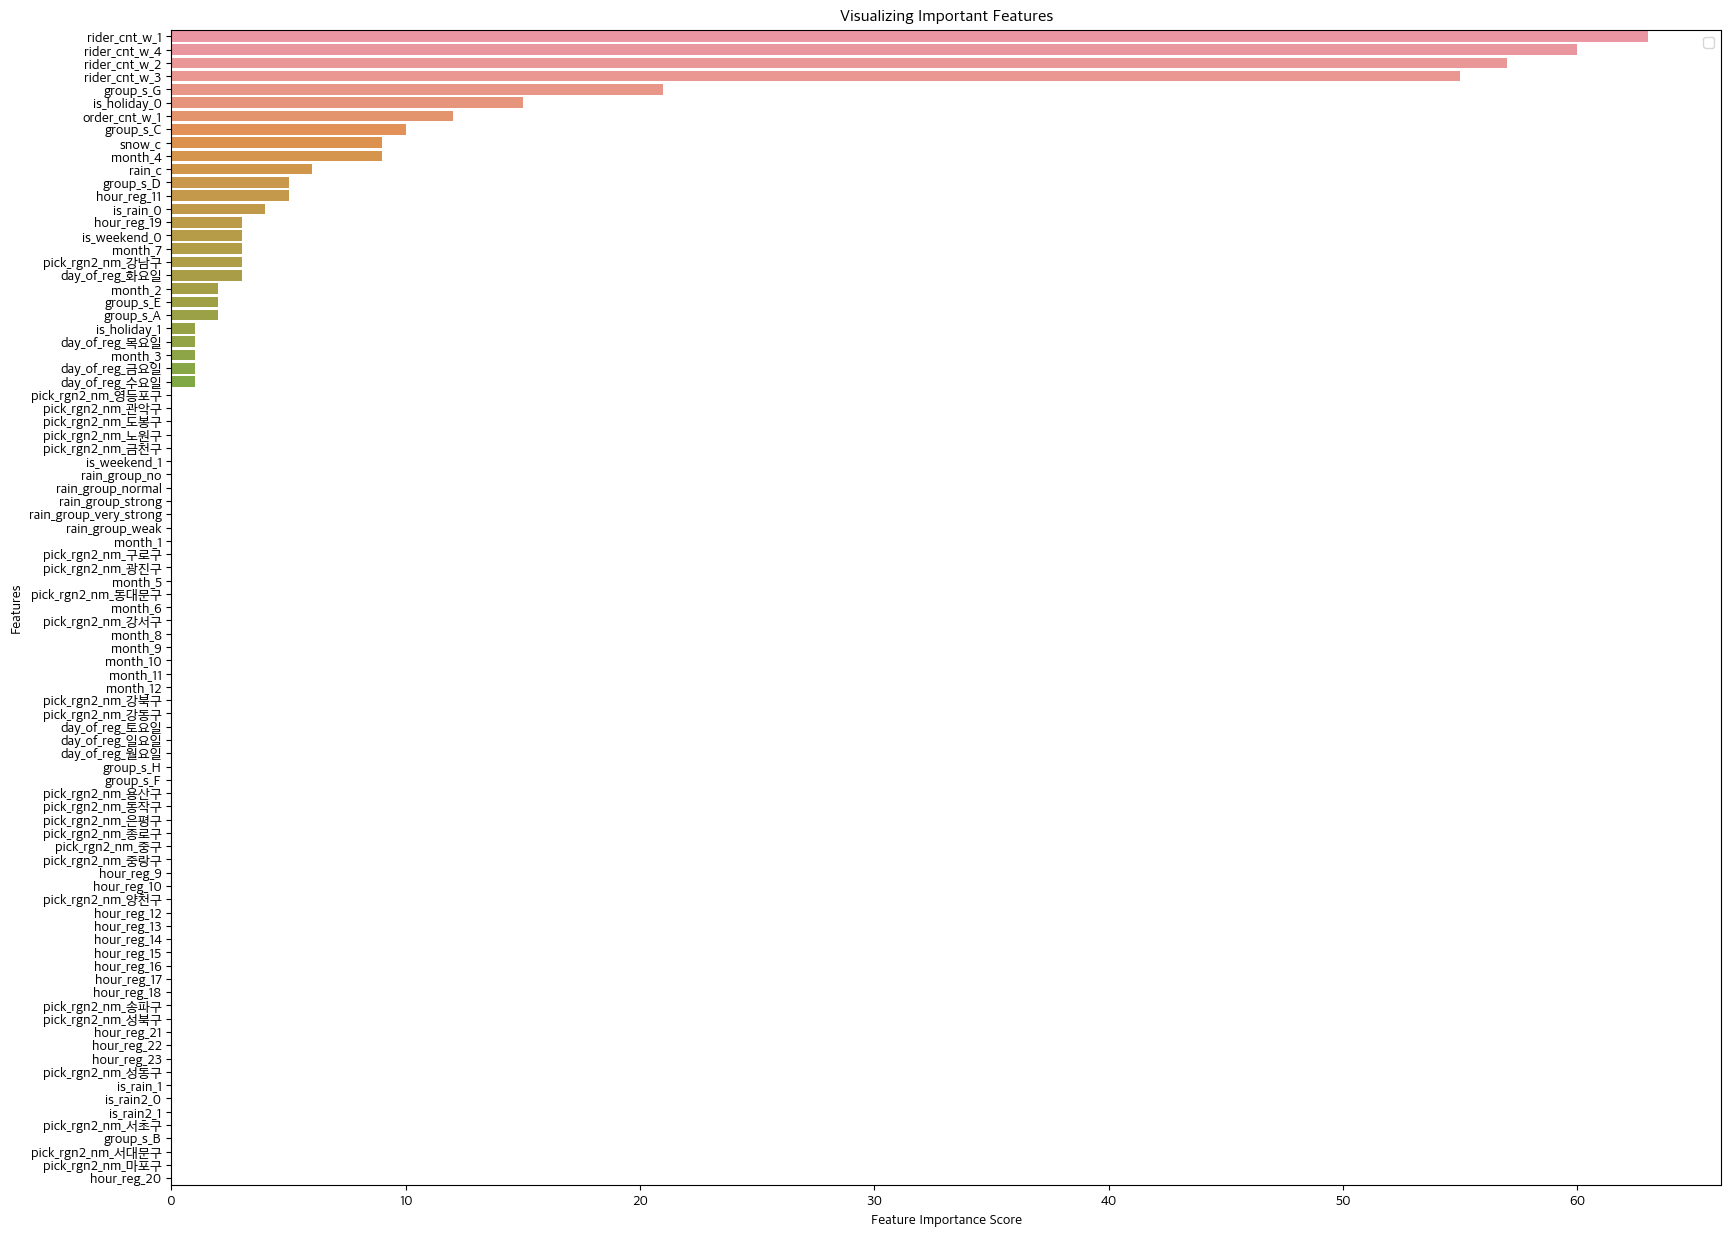

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


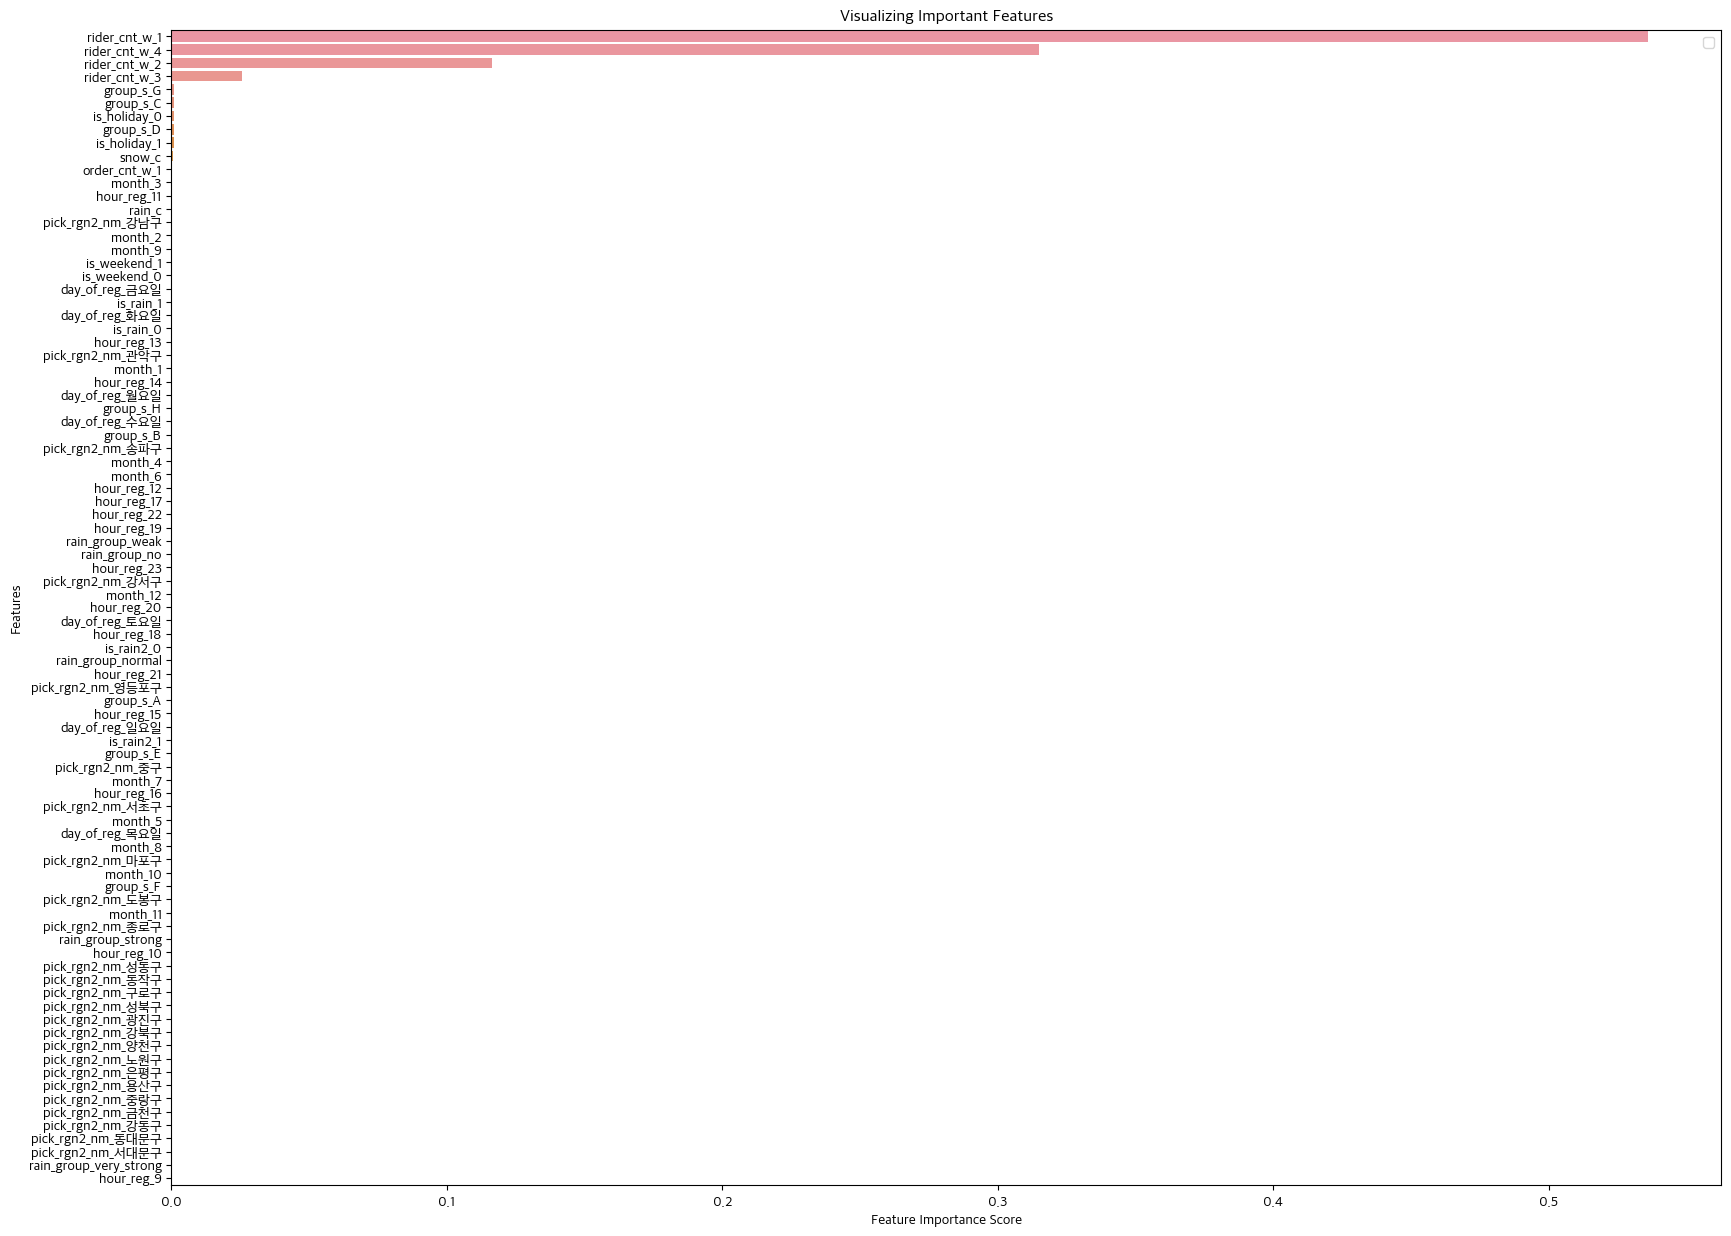

In [46]:
def plot_feature_importances(model, model_name):
    importances = model.feature_importances_
    feat_names = X_train.columns
    feature_imp = pd.Series(importances, index=feat_names).sort_values(ascending=False)

    #print("Feature importances for ", model_name, " : ")
    #print(feature_imp)

    # Creating a bar plot
    plt.figure(figsize = (20,15))
    sns.barplot(x=feature_imp, y=feature_imp.index)
    # Add labels to your graph
    plt.xlabel('Feature Importance Score')
    plt.ylabel('Features')
    plt.title("Visualizing Important Features")
    plt.legend()
    plt.show()

lgbm_model = joblib.load('model_LGBMRegressor.joblib')
plot_feature_importances(lgbm_model, 'LGBMRegressor')

rf_model = joblib.load('model_RandomForestRegressor.joblib')
plot_feature_importances(rf_model, 'RandomForestRegressor')
